# Maths Lab - 3

## Teammates:
#### Akshita Potdar - 702768460
#### Kalyani Khandait - 702768391
#### Logesh Gangadharan - 702723890


## Problem -1

Write a general function to perform K-fold cross-validation for the Lasso.
Inputs:
X : n × p matrix (predictors).
y : n × 1 vector (response variable).
K : integer (number of folds).
alphas: m × 1 vector of lasso parameters



####Importing the libraries


In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

####General function to perform K-fold CV for Lasso

In [ ]:
def k_fold_cv_lasso(X, y, K, alphas):

    m = len(alphas) # Number of alpha values


    cv_err = np.zeros(m) #avg cross-validation error for each alpha(lasso parameter)
    cv_std = np.zeros(m) #standard deviation of the cross-validation error for each alpha(lasso parameter)


    kf = KFold(n_splits=K, shuffle=True, random_state=42) #KFold cross-validation object

    # Looping through each alpha value
    for i, alpha in enumerate(alphas):
        fold_errors = []

        # Performing K-fold cross-validation for the current alpha
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Fitting the Lasso model for the current alpha
            lasso = Lasso(alpha=alpha)
            lasso.fit(X_train, y_train)

            # Predicting on the test set
            y_pred = lasso.predict(X_test)

            # Computing MSE for the test set
            mse = mean_squared_error(y_test, y_pred)
            fold_errors.append(mse)

        # Store the average and standard deviation of errors for the current alpha using NumPy
        cv_err[i] = np.mean(fold_errors)
        cv_std[i] = np.std(fold_errors)

    #the best alpha (lowest average error)
    best_alpha_index = np.argmin(cv_err)
    best_alpha = alphas[best_alpha_index]

    # One-standard deviation rule
    threshold = cv_err[best_alpha_index] + cv_std[best_alpha_index]
    one_sd_alphas = alphas[cv_err <= threshold]

    # Smallest and largest alphas in the one-standard deviation threshold
    best_alpha_onesd_low = np.min(one_sd_alphas)
    best_alpha_onesd_high = np.max(one_sd_alphas)

    return cv_err, cv_std, best_alpha, best_alpha_onesd_low, best_alpha_onesd_high


#### The output

In [ ]:

#input the data
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)

# Define the alpha values to test
alphas = np.logspace(-4, 1, 10)

# Perform n-fold cross-validation for Lasso, here we choose 10
cv_err, cv_std, best_alpha, best_alpha_onesd_low, best_alpha_onesd_high = k_fold_cv_lasso(X, y, K=10, alphas=alphas)

# Print the outputs
print("CV_Err:", cv_err)
print("cv_Std:", cv_std)
print("Best alpha:", best_alpha)
print("Best_alpha_onesd_low:", best_alpha_onesd_low)
print("Best_alpha_onesd_high:", best_alpha_onesd_high)


CV_Err: [1.06063849e-02 1.05978326e-02 1.05783187e-02 1.07292223e-02
 1.34634081e-02 4.92095994e-02 5.12101396e-01 6.49482406e+00
 8.16604017e+01 8.74779632e+02]
cv_Std: [1.19917202e-03 1.19680281e-03 1.19343832e-03 1.22451376e-03
 1.64835797e-03 7.44098909e-03 7.67017052e-02 9.51799734e-01
 1.20829535e+01 1.65142789e+02]
Best alpha: 0.001291549665014884
Best_alpha_onesd_low: 0.0001
Best_alpha_onesd_high: 0.004641588833612782


## Problem -2

The file assay.csv (available in the Westbc folder on Canvas) contains gene
expression data (p = 7, 129 genes) for n = 49 breast cancer tumor samples.
The file pheno.csv contains a binary response variable for each sample
(whether the sample tested positive or negative for cancer

In [ ]:

import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import  matplotlib.pyplot as plt

#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


file_path = '/content/drive/My Drive/Colab Notebooks/DataSets/assay.csv'
X = pd.read_csv(file_path)

file_path_2 = '/content/drive/My Drive/Colab Notebooks/DataSets/pheno.csv'
Y = pd.read_csv(file_path_2)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49
0,-0.203735,-0.155235,0.538864,-0.251111,0.078418,-0.169968,0.477818,1.266249,-0.035189,0.245579,...,0.530661,-0.689984,-0.176092,-0.819852,-0.501200,0.212234,0.771057,0.610961,-0.119870,-0.042511
1,-0.788446,-0.830332,-0.849001,-0.820342,-0.827824,-0.787743,0.727416,0.646691,-0.850607,-0.855351,...,0.709578,-0.779491,0.016839,-0.819852,-0.820997,-0.797696,-0.880880,0.724037,-0.599263,0.055946
2,0.656863,-0.158835,0.660701,1.504918,0.838733,1.435722,0.462233,1.137460,-0.850607,0.117878,...,1.145007,0.766808,0.503271,-0.135008,1.580413,0.130680,0.754790,1.496135,0.492071,0.873854
3,1.691702,-0.830332,1.158440,1.951458,1.606317,0.836362,1.112116,1.402634,0.128394,1.010207,...,1.071905,0.391536,0.344321,0.777783,-0.301728,0.315867,0.970037,1.272469,1.291355,-0.072482
4,-0.867305,-0.830332,-0.849001,-0.820342,-0.552761,-0.787743,-0.318306,-0.745918,-0.850607,-0.855351,...,-0.792841,-0.811639,-0.828833,-0.819852,-0.820997,-0.797696,-0.486966,-0.799975,-0.855050,-0.791519


Split the dataset into a training and a test set. Use the training set to
train a Lasso model to predict the response variable from the gene
expression data. Use cross-validation

In [ ]:
# as the values in labels are in string - needs to be converted into 0/1
# so we do encoding

print(Y.columns)
print(Y['nodal.y'].unique())

Y = Y['nodal.y'].map({'positive': 1, 'negative': 0})

Index(['nodal.y'], dtype='object')
['negative' 'positive']


In [ ]:

X = X.T

# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=32)


Plot the cross-validation error curve (i.e., the average error as a function
of the Lasso parameter α)

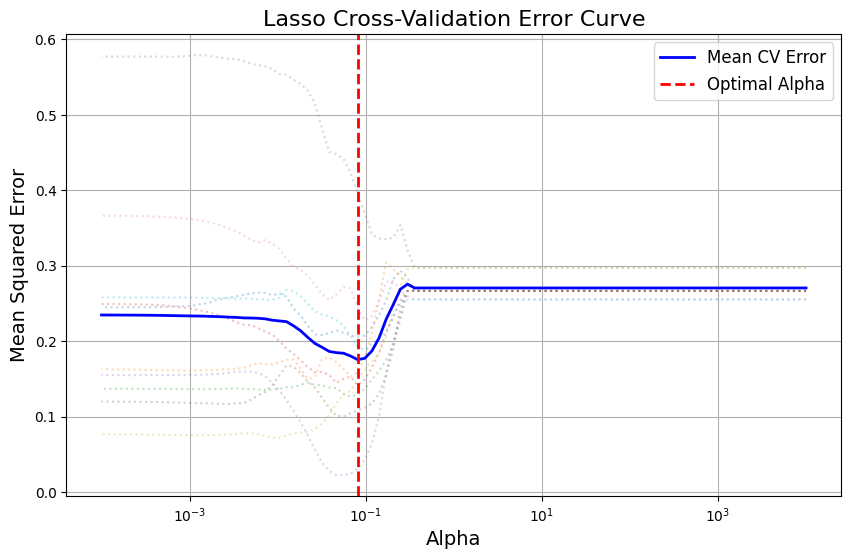

In [ ]:

lasso_cv = LassoCV(alphas=np.logspace(-4, 4, 100), cv=10)
lasso_cv.fit(X_train, Y_train)

# Plot of Graph
plt.figure(figsize=(10, 6))

plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_, ':', alpha=0.3)

plt.plot(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1), 'b', label='Mean CV Error', linewidth=2)
plt.axvline(lasso_cv.alpha_, linestyle='--', color='r', label='Optimal Alpha', linewidth=2)
plt.xscale('log')
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Lasso Cross-Validation Error Curve', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


According to the Lasso, which genes appear to be good predictors for this
type of cancer?

Fit a linear regression model using only the variables selected by the
Lasso with the optimal parameter chosen by cross-validation. Compute
the prediction error on your test set

In [ ]:


# Identify significant genes
coef = pd.Series(lasso_cv.coef_, index=X_train.columns)
significant_genes = coef[coef != 0]
print("Significant genes:", significant_genes)

# Fit a linear regression model  only the selected variables
X_train_selected = X_train.loc[:, significant_genes.index]
X_test_selected = X_test.loc[:, significant_genes.index]


lr = LinearRegression().fit(X_train_selected, Y_train)
y_pred = lr.predict(X_test_selected)
error = mean_squared_error(Y_test, Y_pred)
print("Prediction error on the test set:", error)

# Repeat 100 random
errors = []
for _ in tqdm(range(100), desc="Model Evaluation"):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


    lasso = Lasso(alpha=lasso_cv.alpha_).fit(X_train, y_train)

    # Select features
    selected_features = lasso.coef_ != 0
    X_train_selected = X_train.loc[:, X_train.columns[selected_features]]
    X_test_selected = X_test.loc[:, X_test.columns[selected_features]]


    if X_train_selected.shape[1] > 0:
        lr = LinearRegression().fit(X_train_selected, y_train)
        y_pred = lr.predict(X_test_selected)
        errors.append(mean_squared_error(y_test, y_pred))

# Average error and standard deviation
avg_error = np.mean(errors)
std_error = np.std(errors)
print(f" Average prediction error: {avg_error}, Standard deviation: {std_error}")



# we expect the average prediction error simillar to the one before and also the standard deviation to be minimum asclose to zero as possible

Significant genes: 120     0.079906
131     0.240736
1620   -0.012864
2330    0.066069
3122   -0.025435
3262   -0.010112
3389   -0.019733
3500    0.031199
4171    0.015711
4240   -0.014519
5913   -0.052858
6172   -0.006874
dtype: float64
Prediction error on the test set: 0.2508782173581006


Model Evaluation: 100%|██████████| 100/100 [00:07<00:00, 13.21it/s]

 Average prediction error: 0.20485325577266544, Standard deviation: 0.0635233655071195
